# XGBoost

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style = "darkgrid", palette = "colorblind")

import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.neighbors import NearestNeighbors
from imblearn.over_sampling import RandomOverSampler, SMOTE



from joblib import dump, load # pour enregistrer et charger les modèles.



n_coeurs = 4 # spécifie le nombre de coeurs utilisés sur le processeur par les fonctions qui le permettent

In [48]:
# Instanciation df
df = pd.read_csv('../../../../data/processed/model_weatherAUS.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)
df['Date'] = pd.to_datetime(df['Date'])

###### Proportions initiales target:
#RainTomorrow
#0    0.778382
#1    0.221618

# Séparation data / target:
X = df.drop(columns = ['RainTomorrow', 'Date']).copy()
y = df['RainTomorrow'].copy()

# Séparation du jeu d'entrainement et du jeu de test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123, stratify = y)
# stratify = y assure que la proportion initiale de y se retrouve à l'identique dans les deux échantillons de train et test,
# mais ne permet pas de ré-équilibrer les classes!

# Scale de X_train, X_test:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Oversample avec SMOTE: pour pouvoir spécifier n_jobs, il faut désormais le faire en instanciant en amont un nearest neighbors compatible, ici NearestNeighbors
nn_smote = NearestNeighbors(n_neighbors = 5, n_jobs = n_coeurs)
smote = SMOTE(random_state = 12, k_neighbors = nn_smote)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

print('Classes échantillon SMOTE :', dict(pd.Series(y_sm).value_counts()))

Classes échantillon SMOTE : {0: 82189, 1: 82189}


L'une des particularités de XGBoost est que cet algorithme nécessite que les données soient au format matrix (il n'accepte donc pas DataFrames par exemple).

Le package xgboost permet de créer un objet xgb.DMatrix contenant la matrice des variables et le vecteur des prédictions, à insérer respectivement dans les arguments data et label.


In [49]:
train = xgb.DMatrix(data = X_sm, label = y_sm)
test = xgb.DMatrix(data = X_test, label =  y_test)

In [18]:
booster_params = {'booster': 'gbtree', 'learning_rate': 0.01, 'objective': 'binary:logistic'}
xgb1 = xgb.train(params = booster_params,
                dtrain = train,
                num_boost_round=400,
                early_stopping_rounds = 10,
                evals=[(train, 'train'), (test, 'test')]
                )

[0]	train-logloss:0.68891	test-logloss:0.68919
[1]	train-logloss:0.68475	test-logloss:0.68531
[2]	train-logloss:0.68069	test-logloss:0.68150
[3]	train-logloss:0.67665	test-logloss:0.67774
[4]	train-logloss:0.67267	test-logloss:0.67406
[5]	train-logloss:0.66883	test-logloss:0.67046
[6]	train-logloss:0.66508	test-logloss:0.66691
[7]	train-logloss:0.66138	test-logloss:0.66343
[8]	train-logloss:0.65777	test-logloss:0.66002
[9]	train-logloss:0.65419	test-logloss:0.65667
[10]	train-logloss:0.65070	test-logloss:0.65336
[11]	train-logloss:0.64723	test-logloss:0.65009
[12]	train-logloss:0.64387	test-logloss:0.64693
[13]	train-logloss:0.64054	test-logloss:0.64381
[14]	train-logloss:0.63729	test-logloss:0.64075
[15]	train-logloss:0.63407	test-logloss:0.63775
[16]	train-logloss:0.63092	test-logloss:0.63477
[17]	train-logloss:0.62778	test-logloss:0.63183
[18]	train-logloss:0.62475	test-logloss:0.62895
[19]	train-logloss:0.62172	test-logloss:0.62612
[20]	train-logloss:0.61869	test-logloss:0.62329
[2

In [44]:
preds = xgb1.predict(test)

y_pred = pd.Series(np.where(preds > 0.5, 1, 0))

#pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites'])
print(confusion_matrix(y_test, y_pred))
# Quelque chose ne va pas avec ce crosstab...
# La confusion_matrix fonctionne, elle.

[[23950  3447]
 [ 2403  5397]]


In [34]:
print("Report XGBoost", "\n", classification_report(y_test, y_pred,  digits = 2))

Report XGBoost 
               precision    recall  f1-score   support

           0       0.91      0.87      0.89     27397
           1       0.61      0.69      0.65      7800

    accuracy                           0.83     35197
   macro avg       0.76      0.78      0.77     35197
weighted avg       0.84      0.83      0.84     35197



In [51]:
booster_params = {'booster': 'gbtree', 'learning_rate': 0.1, 'objective': 'binary:logistic'}
xgb1 = xgb.train(params = booster_params,
                dtrain = train,
                num_boost_round=200,
                early_stopping_rounds = 10,
                evals=[(train, 'train'), (test, 'test')]
                )


[0]	train-logloss:0.65226	test-logloss:0.65542
[1]	train-logloss:0.61870	test-logloss:0.62393
[2]	train-logloss:0.59113	test-logloss:0.59746
[3]	train-logloss:0.56746	test-logloss:0.57522
[4]	train-logloss:0.54633	test-logloss:0.55594
[5]	train-logloss:0.52841	test-logloss:0.53911
[6]	train-logloss:0.51277	test-logloss:0.52481
[7]	train-logloss:0.49788	test-logloss:0.51177
[8]	train-logloss:0.48548	test-logloss:0.50052
[9]	train-logloss:0.47344	test-logloss:0.49047
[10]	train-logloss:0.46307	test-logloss:0.48129
[11]	train-logloss:0.45352	test-logloss:0.47309
[12]	train-logloss:0.44500	test-logloss:0.46608
[13]	train-logloss:0.43627	test-logloss:0.45937
[14]	train-logloss:0.42895	test-logloss:0.45335
[15]	train-logloss:0.42146	test-logloss:0.44784
[16]	train-logloss:0.41524	test-logloss:0.44298
[17]	train-logloss:0.40962	test-logloss:0.43890
[18]	train-logloss:0.40392	test-logloss:0.43476
[19]	train-logloss:0.39906	test-logloss:0.43153
[20]	train-logloss:0.39420	test-logloss:0.42782
[2

[[27020   377]
 [ 5073  2727]]
Report XGBoost 
               precision    recall  f1-score   support

           0       0.84      0.99      0.91     27397
           1       0.88      0.35      0.50      7800

    accuracy                           0.85     35197
   macro avg       0.86      0.67      0.70     35197
weighted avg       0.85      0.85      0.82     35197



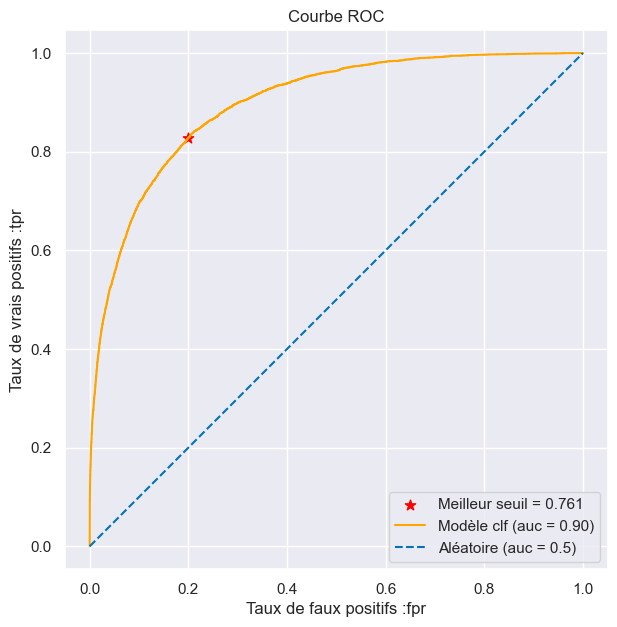

Report XGBoost 
               precision    recall  f1-score   support

           0       0.84      0.99      0.91     27397
           1       0.88      0.35      0.50      7800

    accuracy                           0.85     35197
   macro avg       0.86      0.67      0.70     35197
weighted avg       0.85      0.85      0.82     35197

[[27020   377]
 [ 5072  2728]]


In [121]:
# On fait la prediction sur test:
preds = xgb1.predict(test)

################################ On cherche le meilleur seuil:
# Création des arrays fpr, tpr et seuils:
fpr, tpr, seuils = roc_curve(y_test, preds, pos_label = 1)

# Pour calculer l'aire sous la courbe ROC:
roc_auc = auc(x = fpr, y = tpr)

# Comment trouver le meilleur seuil?
dist = 1
for (x, y, s) in zip(fpr, tpr, seuils):
    dist1 = np.square(x**2 + (y-1)**2)
    if dist1 < dist:
        dist = dist1
        seuil_best = 1 - s # pourquoi dois-je faire ça?
        fpr_best = x
        tpr_best = y

#print("Meilleur seuil:", seuil_best, "meilleur fpr:", fpr_best, "meilleur tpr:", tpr_best)

# Tracé de ROC:
plt.figure(figsize = (7, 7))
plt.axis('equal')

plt.scatter(fpr_best, tpr_best, s = 60, c = 'red', marker = '*', alpha = 1, label = "Meilleur seuil = %0.3f" % seuil_best)
plt.plot(fpr, tpr, c = 'orange', label = 'Modèle clf (auc = %0.2f)' % roc_auc)
plt.plot(fpr, fpr, 'b--', label = 'Aléatoire (auc = 0.5)')

plt.title('Courbe ROC XGBoost')
plt.xlabel('Taux de faux positifs :fpr')
plt.ylabel('Taux de vrais positifs :tpr')
plt.legend()

plt.show()

################### On applique le meilleur seuil:
y_pred = pd.Series(np.where(preds > seuil_best, 1, 0))

print("Report XGBoost", "\n", classification_report(y_test, y_pred,  digits = 2))
print(confusion_matrix(y_test, y_pred))

Bilan: meilleur modèle jusqu'à présent avec Voting Soft seuillé (14 nov 23, 11h50).  
Le tout sans chercher à l'optimiser. Peut être faut-il creuser dans cette voie: l'optimisation de XGBoost?